In [1]:
root_path = 'C:\\...\\Supervised-ML-BankPrediction-Classification\\data\\'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


seed = 42

In [3]:
df = pd.read_csv(root_path + 'bank_marketing_campaign.csv')

### Data Cleaning and Preprocessing

In [5]:
#Handling "age"" Outliers


df = df[df['age'] <= 85]

In [6]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['y'], axis = 'columns')
y_train = train_set['y']

X_test = test_set.drop(['y'], axis = 1)
y_test = test_set['y']

In [11]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*2000
    cost_fp = fp*500
    
    return cost_fn + cost_fp

In [12]:
def min_cost_threshold(y_test, y_preds):
    costs = {}
    for threshold in np.arange(0, 1.1, 0.1):
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold)
    min_threshold = min(costs, key=costs.get)
    return costs[min_threshold], min_threshold
    

In [13]:
import mlflow
from pathlib import Path

# Set the MLflow tracking URI

# Use an absolute path
mlflow.set_tracking_uri('file:///c:/.../Supervised-ML-BankPrediction-Classification/mlruns')

In [14]:
# Define MLflow Experiment for Logistic Regression
mlflow.set_experiment("Random Forest Experiment")

2024/08/13 13:47:36 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/polin/OneDrive/Documents/GitHub/Supervised-ML-BankPrediction-Classification/mlruns/285512569137283403', creation_time=1723549656009, experiment_id='285512569137283403', last_update_time=1723549656009, lifecycle_stage='active', name='Random Forest Experiment', tags={}>

In [15]:
mlflow.end_run()

Successfully registered model 'random_forest'.
Created version '1' of model 'random_forest'.


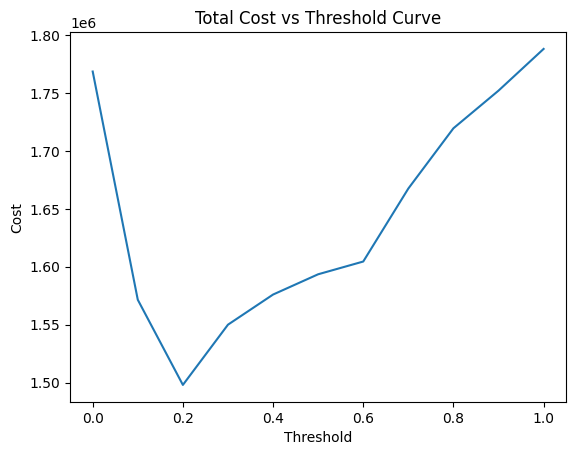

In [17]:
# Define the preprocessing for numerical features
numerical_features = ['age', 'pdays', 'previous', 'emp_var_rate', 
                      'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
numerical_transformer = MinMaxScaler()

# Define the preprocessing for categorical features
categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']
categorical_transformer = OneHotEncoder()

# Ordinal Encoding for 'education'
ordinal_features = ['education']
ordinal_transformer = OrdinalEncoder(categories=[["unknown", "illiterate", "basic.4y", "basic.6y", "basic.9y", 
                                                  "high.school", "professional.course", "university.degree"]])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

# PCA
pca = PCA(n_components=14)

rf = RandomForestClassifier(random_state = seed,  class_weight = 'balanced')

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('rf', rf)
])

parameters = {'n_estimators':[10, 100, 300, 1000]}

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with mlflow.start_run(run_name="Random Forest Run", nested = True):
    # Train GridSearchCV with the pipeline
    clf_rf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    
    # Predict probabilities for test data
    y_probs = clf_rf.predict_proba(X_test)[:, 1]
    
    # Evaluate logistic regression model
    score = clf_rf.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_probs > 0.5).ravel()
    
    # Calculate total cost and minimum cost threshold
    cost, min_threshold = total_cost(y_test, y_probs), min_cost_threshold(y_test, y_probs)
    
    # Log parameters, metrics, and model artifacts with MLflow
    mlflow.log_params(clf_rf.best_params_)
    mlflow.log_metric("accuracy", score)
    mlflow.log_metric("total_cost", cost)
    mlflow.log_metric("min_cost_threshold", min_threshold[0])
    
    
    # Plot total cost vs threshold curve
    thresholds = np.arange(0, 1.1, 0.1)
    costs = [total_cost(y_test, y_probs, threshold) for threshold in thresholds]
    plt.plot(thresholds, costs)
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.title('Total Cost vs Threshold Curve')
    plt.savefig('total_cost_vs_threshold.png')
    mlflow.log_artifact('total_cost_vs_threshold.png')

    # Log the final model
    mlflow.sklearn.log_model(clf_rf.best_estimator_, artifact_path="rf", registered_model_name="random_forest", input_example=X_train)

In [18]:
params=rf.get_params()
mlflow.log_params(params)
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [19]:
mlflow.end_run()